<a href="https://colab.research.google.com/github/keyanUB/cuadvancelab.github.io/blob/main/instructions/lab2/computer-sciencelab2_interactive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2 AI for Multimodal Cyberharassment Detection



With previous lab learning, you should have some knowledge about how to develop an AI model to detect cyberbullying lauguage. In this lab, we will keep learning how AI can be developed to detect cyberbullying. We will use a publicly available test dataset of cyberbullying images, and deploy an pre-trained AI model to automatically detect cyberbullying images. 
Approach towards analysing the cyber bullying in images in a dataset, there are three steps: 
1. Understand and identify the factors related to cyberbullying in images. 
2. Extract those factors from images.
3. Examine the usage of those factors in classifier models

## Download the pre-trained model, test dataset and the dependencies

First, we need to download the pre-trained model and the test dataset used in the lab. Just hit the 'play' button run the code below.

In [ ]:
 # download the model and dataset
!wget -O auxes_17.pt https://buffalo.box.com/shared/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
!wget -O cyberbullying_data.zip https://buffalo.box.com/shared/static/bxfnnz2ln9gmzoojxs4nuafzhqildnvi.zip

--2022-10-11 13:29:28--  https://buffalo.box.com/shared/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Resolving buffalo.box.com (buffalo.box.com)... 74.112.186.144
Connecting to buffalo.box.com (buffalo.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt [following]
--2022-10-11 13:29:28--  https://buffalo.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Reusing existing connection to buffalo.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://buffalo.app.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt [following]
--2022-10-11 13:29:28--  https://buffalo.app.box.com/public/static/cjk39hq7prpwj2rkqz6lc2jr6q2h5shy.pt
Resolving buffalo.app.box.com (buffalo.app.box.com)... 74.112.186.144
Connecting to buffalo.app.box.com (buffalo.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Fo

In [ ]:
# unzip the test data
%%capture
!unzip "/content/cyberbullying_data.zip" -d "/content"

Let's import all our softwares dependencies in our iPython notebook

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch.utils.data as data_utils
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

In [ ]:
import pickle
import gzip
import sys
import time
import numpy as np
import math
import os
import random
from skimage import io, transform

## Load datasets

Now, let's run the subsequent codes to load your data from a predefined
class

In [ ]:
class PosesDataset(Dataset):

  def __init__(self, root_dir, poses_dir, auxes_dir):

    self.samples = []
    self.root_dir = root_dir
    self.poses_dir = poses_dir
    self.auxes_dir = auxes_dir

    for _, _, cb_images in os.walk(self.root_dir + 'cyberbullying'): break
    for _, _, non_cb_images in os.walk(self.root_dir + 'non_cyberbullying'): break
    for _, _, cb_poses in os.walk(self.poses_dir + 'cyberbullying'): break
    for _, _, non_cb_poses in os.walk(self.poses_dir + 'non_cyberbullying'): break

    for i in cb_images:
      self.samples.append((self.root_dir + 'cyberbullying/' + i, self.poses_dir + 'cyberbullying/' + i, self.auxes_dir + 'cyberbullying/' + i, 1))  

    for i in non_cb_images:
      self.samples.append((self.root_dir + 'non_cyberbullying/' + i, self.poses_dir + 'non_cyberbullying/' + i, self.auxes_dir + 'non_cyberbullying/' + i, 0))


  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_name, pose_name, aux_name, label = self.samples[idx]
    image = io.imread(img_name)

    aux = pickle.load(open(aux_name + '.p', 'rb'))
    aux = torch.tensor(aux)
    
    if image.shape == (224, 224): 
      # handle grayscale images   
      image = np.stack([image, image, image], axis=2)

    if image.shape == (224, 224, 4):
      image = image[:,:,:3]

    image = image.transpose((2, 0, 1)) # C X H X W
    pose = io.imread(pose_name)
    if pose.shape != (224, 224):
      pose = pose[:,:,0]
    pose = np.expand_dims(pose, axis = 0)
    image = np.concatenate((image, pose), axis = 0)
    sample = {'image': torch.from_numpy(image.copy()).float() / 255, 'aux': aux, 'label': label}
    return sample

In [ ]:
valid_set = PosesDataset('cyberbullying_data/cyberbullying_data_splits_clean/test/', 'cyberbullying_data/cyberbullying_poses/test/', 'cyberbullying_data/cyberbullying_data_auxes/test/')
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = 1, shuffle = True)

## Load pre-trained AI model

We will use GPU to test our AI if it is available.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Let's load the pre-trained model to test its capability

In [ ]:
# load vgg16 pre-trained model
orig = models.vgg16(pretrained = True)

In [ ]:
class CB(nn.Module):
  def __init__(self):
    super(CB, self).__init__()
    self.conv1 = nn.Conv2d(4, 3, 1)
    self.f = nn.Sequential(*list(orig.features.children()))
    self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
    self.aux_classifier = nn.Sequential(
      nn.Linear(25097, 1024),
      nn.ReLU(),
      nn.Linear(1024, 25088),
      nn.ReLU()  
    )   
    self.classifier = nn.Sequential(*list(orig.classifier.children()))
    self.classifier[-1] = nn.Linear(4096, 2)
    self.sig = nn.Sigmoid()
 
  def forward(self, x, aux):
    x = self.conv1(x) 
    x = self.f(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1) 
    x = torch.cat((x, aux), dim = 1)
    x = self.aux_classifier(x)
    x = self.classifier(x)
    x = self.sig(x) 


    return x


Pass the pre-trained checkpoints to the VGG model so that you can have our pre-trained model

In [ ]:
model = torch.load("auxes_17.pt")
model.to(device)

criterion = nn.CrossEntropyLoss()

running_loss = []
correct, incorrect, total = 0., 0., 0.

## Generate the detection resuls for validation data

Now, it's time to evaulate the pre-trained model's capability with our test dataset

In [ ]:
with torch.no_grad():
  for i_v, data_v in enumerate(valid_loader):
    x_valid, y_valid, aux_valid = data_v['image'], data_v['label'], data_v['aux']
    x_valid, y_valid, aux_valid = x_valid.to(device), y_valid.to(device, dtype = torch.long), aux_valid.to(device, dtype = torch.float)
    y_valid_ = model(x_valid, aux_valid)
    running_loss.append(criterion(y_valid_, y_valid))
    _, predicted = torch.max(y_valid_.data, 1)
    total += y_valid.size(0)
    correct += (predicted == y_valid).sum().item() 

print('Val loss is: {:.3f}'.format((sum(running_loss) / len(running_loss)).item()))
print('The accuracy for validation dataset is: {}%'.format((correct / total) * 100))


Val loss is: 0.463
The accuracy for validation dataset is: 85.0%


## Let's check with one instance

To better understand the performance, you can try to visualize one instance in the dataset

In [ ]:
# random select an instance in validation dataset
random_index = random.randrange(len(valid_set))
instance = valid_set[random_index]

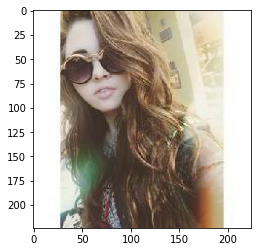

The label of this image is: non-cyberbullying


In [ ]:
# plot the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(valid_set.samples[random_index][0])
imgplot = plt.imshow(img)
plt.show()
annot_label = "cyberbullying" if valid_set[random_index]['label']==1 else "non-cyberbullying"
print("The label of this image is: {}".format(annot_label))

Run the following code cell to check the AI's prediction

In [ ]:
from numpy.ma.core import outerproduct
# check if the prediction is correct
instance_image, instance_label, instance_aux = instance['image'].to(device), torch.tensor(instance['label']).to(device, dtype = torch.long), instance['aux'].to(device, dtype = torch.float)

output = model(instance_image.unsqueeze(0), instance_aux.unsqueeze(0)).data
_, prediction = torch.max(output.data, 1)
predict_label = "cyberbullying" if prediction.item()==1 else "non-cyberbullying"
comparision = "correct" if prediction==instance_label else "not correct"

print("The AI prediction for this image is: {}, which is {}!".format(annot_label, comparision))

The AI prediction for this image is: non-cyberbullying, which is correct!
